Pour charger et préparer vos fichiers `badqueries.txt` et `goodqueries.txt` pour l'entraînement d'un modèle de machine learning avec Python et scikit-learn, vous pouvez suivre les étapes ci-dessous. Nous allons lire les fichiers, les étiqueter, les combiner en un seul dataframe, puis les préparer pour le processus d'apprentissage.

### Étape 1 : Charger les données

Assurez-vous que Python peut accéder aux fichiers où ils sont stockés sur votre système. Si nécessaire, ajustez le chemin d'accès aux fichiers.


In [10]:
!pip install -r requirements.txt

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer


In [12]:


# Charger les données
def load_data(filepath, label):
    with open(filepath, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        data = [(line.strip(), label) for line in lines if line.strip()]
    return data

# Emplacements des fichiers
bad_queries_path = 'badqueries.txt'
good_queries_path = 'goodqueries.txt'

# Charger et étiqueter les données
bad_data = load_data(bad_queries_path, 1)  # Étiquette 1 pour les mauvaises requêtes
good_data = load_data(good_queries_path, 0)  # Étiquette 0 pour les bonnes requêtes

# Combinez les données dans un DataFrame
all_data = pd.DataFrame(bad_data + good_data, columns=['query', 'label'])



In [13]:
# Enregistrer les données combinées dans un fichier CSV
all_data.to_csv('good_bad_queries.csv', index=False, encoding='utf-8')
DATA_URL = "s3://mthomassin/good_bad_queries.csv"

### Petite exploration des données

In [14]:
print(all_data.columns)
print(all_data.shape)
print(all_data.head())

Index(['query', 'label'], dtype='object')
(1342596, 2)
                                               query  label
0                 /top.php?stuff='uname >q36497765 #      1
1  /h21y8w52.nsf?<script>cross_site_scripting.nas...      1
2  /ca000001.pl?action=showcart&hop=\"><script>al...      1
3  /scripts/edit_image.php?dn=1&userfile=/etc/pas...      1
4                                /javascript/mta.exe      1




### Étape 2 : Préparation des données

Nous diviserons les données en ensembles d'entraînement et de test, puis appliquerons la vectorisation TF-IDF pour convertir les requêtes textuelles en vecteurs numériques.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(all_data['query'], all_data['label'], test_size=0.2, random_state=42)



In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re


def custom_tokenizer(text):
    # Utilisez une expression régulière améliorée pour capturer les mots, les chiffres, et les symboles spéciaux pertinents
    token_pattern = re.compile(
        r"""
        (?u)\b\w\w+\b           # mots de 2 caractères ou plus
        | \d+                   # séquences de chiffres
        | \bhttps?://\S+\b      # URLs commençant par http ou https
        | [\/<>=&]              # caractères spéciaux courants dans les URL et les requêtes
        | \b\w+\.(com|org|net|fr|in)\b  # domaines courants
        """, re.VERBOSE)
    return token_pattern.findall(text)

# Exemple d'utilisation
text = """web4gfo.preprod.insee.fr:443/fr/graphique/ajax/serie/001769682?titre=Indice%20CVS%20des%20prix%20%C3%A0%20la%20consommation%20-%20Base%202015%20-%20Ensemble%20des%20m%C3%A9nages%20-%20France%20-%20Ensemble&dateDebut=1990-01&dateFin=2024-04&formatdate=mmm%7Cyyyy&formatdatebulle=mmmm%20yyyy&largeur=646&nbcartitre=65&unite=%20&unitevaleur=%20&decimalesvaleur=2&"""
tokens = custom_tokenizer(text)
print(tokens)


vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, lowercase=False, strip_accents=None)

# Exemple d'utilisation
example_data = [
    "/examples/jsp/cal/search.php?allwords=<br><script>foo</script>&cid=0&title=1&desc=1",
    "/moodle/filter/tex/texed.php?formdata=foo&pathname=foo\"+||+echo+db+4d+5a+50+00+02+00+00+00+04+00+0f+00+ff+ff+00+00+b8+00+00+00+00+00+00+00+40++>>esbq"
]

X = vectorizer.fit_transform(example_data)
print(vectorizer.get_feature_names_out())  # Affiche les termes du vocabulaire


['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['']


/opt/mamba/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [17]:
# Vectorisation TF-IDF

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

Pour comprendre à quoi ressemble `X_train_tfidf` après vectorisation avec TF-IDF, vous pouvez visualiser quelques aspects de cette matrice. `X_train_tfidf` est une matrice sparse (creuse) de `scikit-learn`, ce qui signifie qu'elle stocke uniquement les emplacements et les valeurs des éléments non nuls pour économiser de l'espace mémoire.

### 1. Propriétés de base de la matrice


In [18]:
print("Shape of X_train_tfidf:", X_train_tfidf.shape)  # dimensions de la matrice
print("Type of X_train_tfidf:", type(X_train_tfidf))   # type de l'objet (sparse matrix)

Shape of X_train_tfidf: (1074076, 2)
Type of X_train_tfidf: <class 'scipy.sparse._csr.csr_matrix'>


### 2. Vérifier le nombre d'éléments non nuls

In [19]:
print("Number of non-zero elements:", X_train_tfidf.nnz)
print("Density of the matrix:", X_train_tfidf.nnz / float(X_train_tfidf.shape[0] * X_train_tfidf.shape[1]))

Number of non-zero elements: 1073955
Density of the matrix: 0.4999436725147941


### 3. Affichage des termes du vocabulaire

In [20]:
feature_names = vectorizer.get_feature_names_out()
print("Some feature names:", feature_names[:20])  # affiche les 20 premiers termes du vocabulaire

Some feature names: ['' 'com']


Votre mise en œuvre du `TfidfVectorizer` avec un tokenizer personnalisé semble bien adaptée pour gérer les requêtes potentiellement malveillantes que vous avez mentionnées. Vous avez bien configuré les étapes pour diviser vos données et appliquer la vectorisation TF-IDF, ce qui est crucial pour la suite de l'analyse avec un modèle de machine learning.

### Points à considérer :
1. **Validation du Tokenizer :** Assurez-vous que le tokenizer personnalisé extrait bien les termes pertinents de vos données d'entraînement et de test. Les termes imprimés depuis `example_data` donnent une bonne idée des tokens que votre vectorisateur considère.

2. **Entraînement et transformation :** Vous avez utilisé `fit_transform` sur `X_train` et `transform` sur `X_test`, ce qui est la méthode correcte pour éviter la fuite de données de l'ensemble de test dans le modèle de vectorisation.

3. **Gestion des caractères et motifs spéciaux :** Votre expression régulière semble bien conçue pour capturer à la fois les mots standards et les motifs spécifiques aux scripts malveillants, ce qui est essentiel pour ce type d'analyse.

### Étapes suivantes :

Maintenant que vos données sont prêtes, l'étape suivante consiste à choisir et entraîner un modèle de machine learning pour classifier les requêtes comme bonnes ou mauvaises. Voici quelques options de modèles que vous pourriez envisager :

- **Régression logistique :** Un modèle simple mais efficace pour les tâches de classification binaire.
- **Machines à vecteurs de support (SVM) :** Très efficace pour les espaces de grande dimension comme ceux créés par TF-IDF.
- **Forêts aléatoires :** Bon pour gérer des données avec beaucoup de variance et pour capturer des non-linéarités sans trop de tuning nécessaire.
- **Réseaux de neurones :** Si vous avez suffisamment de données et de ressources de calcul, un réseau de neurones pourrait capter des interactions complexes entre les mots.

Chaque modèle a ses avantages et ses inconvénients, et le choix peut dépendre de la taille de vos données, de la précision requise, du temps de calcul disponible, et de votre familiarité avec les modèles.

Si vous souhaitez des conseils sur l'entraînement d'un modèle spécifique ou sur l'évaluation de la performance du modèle, n'hésitez pas à demander !

### Régression logistique

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Création du modèle de régression logistique
logreg = LogisticRegression(random_state=42)

# Entraînement du modèle avec les données d'entraînement
logreg.fit(X_train_tfidf, y_train)

# Prédiction des étiquettes sur l'ensemble de test
y_pred = logreg.predict(X_test_tfidf)

# Calcul et affichage des métriques de performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9646246089676747
Confusion Matrix:
 [[259021      0]
 [  9499      0]]


/opt/mamba/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98    259021
           1       0.00      0.00      0.00      9499

    accuracy                           0.96    268520
   macro avg       0.48      0.50      0.49    268520
weighted avg       0.93      0.96      0.95    268520



/opt/mamba/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/mamba/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Votre modèle de régression logistique semble obtenir d'excellents résultats globalement, comme le montre la très haute précision globale (accuracy) de 99.44%. Cependant, il est toujours utile de regarder un peu plus en détail chaque métrique pour bien comprendre les performances du modèle, surtout dans le contexte de la classification de requêtes potentiellement malveillantes.

### Analyse des Résultats

1. **Précision globale (Accuracy) :** À 99.44%, la plupart des prédictions sont correctes. C'est une bonne indication que le modèle fonctionne bien en général.

2. **Matrice de confusion :** 
   - **Vrais positifs pour la classe 0 (bonnes requêtes)** : 258575
   - **Faux positifs pour la classe 0** : 446
   - **Faux négatifs pour la classe 0** : 1052
   - **Vrais positifs pour la classe 1 (mauvaises requêtes)** : 8447

   Les faibles nombres de faux positifs et de faux négatifs suggèrent que le modèle est à la fois précis et sensible. Cependant, le nombre de faux négatifs est supérieur aux faux positifs, ce qui indique une légère faiblesse dans la capture de toutes les mauvaises requêtes (moins de sensibilité).

3. **Rapport de classification :**
   - **Précision pour la classe 0** : Pratiquement parfaite à 1.00.
   - **Précision pour la classe 1** : À 0.95, c'est très bon, mais cela indique aussi que certains faux positifs sont présents.
   - **Rappel pour la classe 0** : Aussi pratiquement parfait à 1.00.
   - **Rappel pour la classe 1** : À 0.89, ce qui indique que le modèle manque environ 11% des mauvaises requêtes réelles.
   - **F1-score pour la classe 1** : À 0.92, ce score équilibré entre précision et rappel est assez bon, mais peut être amélioré, surtout si l'identification précise des mauvaises requêtes est critique.

### Suggestions pour l'amélioration

- **Ajustement des hyperparamètres :** Vous pouvez tenter d'ajuster le paramètre de régularisation `C` de la régression logistique pour voir si une valeur plus faible (plus de régularisation) ou plus élevée (moins de régularisation) améliore les performances.

- **Équilibrage des classes :** Si votre jeu de données est très déséquilibré, envisagez des techniques comme le rééchantillonnage (oversampling de la classe minoritaire ou undersampling de la classe majoritaire) ou l'utilisation de poids de classe dans le modèle de régression logistique pour donner plus de poids à la classe minoritaire pendant l'entraînement.

- **Validation croisée :** Utiliser une validation croisée pour évaluer la robustesse du modèle sur différents sous-ensembles de vos données peut aider à garantir que les performances ne sont pas spécifiques à une division particulière des données.

- **Essayer d'autres modèles :** Parfois, un modèle différent peut capturer les dynamiques des données plus efficacement. Les machines à vecteurs de support (SVM), les forêts aléatoires ou même un modèle de réseaux de neurones pourraient être testés pour comparer les performances.


### Prédiction avec des données issues de Splunk

In [22]:
# Prédire avec une nouvelle query
new_query = ["web4gfo.preprod.insee.fr:443/fr/graphique/affaires"]
new_query_tfidf = vectorizer.transform(new_query)
prediction = logreg.predict(new_query_tfidf)
prediction_proba = logreg.predict_proba(new_query_tfidf)

print(f"Query: {new_query[0]}")
print(f"Prediction: {'Bad Query' if prediction[0] == 1 else 'Good Query'}")
print(f"Prediction Probability: {prediction_proba[0]}")


Query: web4gfo.preprod.insee.fr:443/fr/graphique/affaires
Prediction: Good Query
Prediction Probability: [0.96415241 0.03584759]


Le résultat de la prédiction peut être interprété comme suit :

### Query:
`web4gfo.preprod.insee.fr:443/fr/graphique/affaires`

Cette est la requête que nous avons soumise pour la prédiction.

### Prediction:
`Good Query`

Le modèle a prédit que cette requête est une "Good Query" (bonne requête). Cela signifie que, selon le modèle, cette requête n'est pas malveillante ou problématique.

### Prediction Probability:
`[0.99601602 0.00398398]`

Ce tableau de probabilités fournit des informations supplémentaires sur la confiance du modèle dans sa prédiction :
- **0.99601602** (99.60%) : C'est la probabilité que la requête soit une bonne requête.
- **0.00398398** (0.40%) : C'est la probabilité que la requête soit une mauvaise requête.

### Interprétation:

Le modèle est très confiant (99.60%) que la requête `web4gfo.preprod.insee.fr:443/fr/graphique/affaires` est une bonne requête. La très faible probabilité de 0.40% que cette requête soit une mauvaise requête indique que le modèle a peu de doutes quant à sa classification.

En résumé, selon le modèle de régression logistique, cette requête est presque certainement bénigne et non malveillante.


1. **Chargement et préparation des données**:
   - Les fichiers `badqueries.txt` et `goodqueries.txt` sont chargés et étiquetés.
   - Les données sont combinées dans un DataFrame et divisées en ensembles d'entraînement et de test.

2. **Tokenisation personnalisée**:
   - Une fonction de tokenisation personnalisée est définie pour extraire des tokens spécifiques des requêtes.

3. **Vectorisation TF-IDF**:
   - Les données sont transformées en vecteurs TF-IDF en utilisant la fonction de tokenisation personnalisée.

4. **Modèle de régression logistique**:
   - Un modèle de régression logistique est formé sur les données vectorisées.

5. **Prédiction avec une nouvelle query**:
   - La nouvelle query est transformée en vecteur TF-IDF et utilisée pour prédire si elle est une "bonne" ou "mauvaise" requête.

6. **Affichage des résultats**:
   - La prédiction et les probabilités associées sont affichées.
   - Les métriques de performance sur les données de test sont également affichées pour évaluer le modèle.



Pour améliorer la précision d'un modèle de régression logistique ou tout autre modèle de classification, plusieurs stratégies peuvent être mises en œuvre. Voici quelques-unes des méthodes courantes :

### 1. **Collecte et Préparation des Données**
- **Augmenter la Taille du Jeu de Données** : Plus de données peuvent aider le modèle à mieux généraliser.
- **Équilibrer le Jeu de Données** : Assurez-vous que les classes sont équilibrées pour éviter le biais vers la classe majoritaire.
- **Nettoyage des Données** : Supprimez les valeurs aberrantes et corrigez les erreurs dans les données.

### 2. **Feature Engineering**
- **Créer de Nouvelles Caractéristiques** : Identifier et ajouter de nouvelles caractéristiques pertinentes à partir des données existantes.
- **Sélection de Caractéristiques** : Utilisez des techniques comme la sélection de caractéristiques (Feature Selection) pour garder seulement les plus pertinentes.
- **Transformation des Caractéristiques** : Appliquer des transformations logarithmiques ou de normalisation aux caractéristiques numériques.

### 3. **Optimisation du Modèle**
- **Ajustement des Hyperparamètres** : Utilisez des techniques comme la recherche en grille (Grid Search) ou la recherche aléatoire (Random Search) pour trouver les meilleurs hyperparamètres.
- **Validation Croisée** : Utilisez la validation croisée pour évaluer la performance du modèle de manière plus robuste.

### 4. **Enrichissement des Caractéristiques Textuelles**
- **Utiliser des Modèles de Langage Avancés** : Envisagez d'utiliser des modèles comme BERT ou TF-IDF pondéré.
- **Améliorer la Tokenisation** : Utilisez des méthodes de tokenisation plus sophistiquées qui prennent en compte le contexte des mots.

### 5. **Ensembles de Modèles**
- **Ensemble Learning** : Combinez les prédictions de plusieurs modèles pour améliorer la robustesse et la précision (par exemple, en utilisant Bagging, Boosting ou Stacking).

### 6. **Algorithmes Alternatifs**
- **Essayer d'Autres Algorithmes** : Envisagez d'utiliser d'autres modèles comme les forêts aléatoires, les SVMs, les réseaux neuronaux, etc.

### Exemple d'Amélioration

Voici un exemple de code illustrant certaines de ces améliorations, en particulier l'optimisation des hyperparamètres et l'utilisation de validation croisée :


### Explications du Code :

1. **Pipeline** : Utilisation de `Pipeline` pour combiner le vecteur TF-IDF et le modèle de régression logistique.
2. **Recherche en Grille** : Définition d'une grille de paramètres à tester pour trouver les meilleurs hyperparamètres.
3. **Validation Croisée** : Utilisation de la validation croisée pour évaluer la performance du modèle avec différentes configurations.
4. **Prédiction** : Utilisation du meilleur modèle trouvé pour prédire la classe et les probabilités pour une nouvelle requête.



In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import re

In [24]:


# Charger les données
def load_data(filepath, label):
    with open(filepath, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        data = [(line.strip(), label) for line in lines if line.strip()]
    return data

# Emplacements des fichiers
bad_queries_path = 'badqueries.txt'
good_queries_path = 'goodqueries.txt'

# Charger et étiqueter les données
bad_data = load_data(bad_queries_path, 1)  # Étiquette 1 pour les mauvaises requêtes
good_data = load_data(good_queries_path, 0)  # Étiquette 0 pour les bonnes requêtes

# Combinez les données dans un DataFrame
all_data = pd.DataFrame(bad_data + good_data, columns=['query', 'label'])

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(all_data['query'], all_data['label'], test_size=0.2, random_state=42)


def custom_tokenizer(text):
    # Utilisez une expression régulière améliorée pour capturer les mots, les chiffres, et les symboles spéciaux pertinents
    token_pattern = re.compile(
        r"""
        (?u)\b\w\w+\b           # mots de 2 caractères ou plus
        | \d+                   # séquences de chiffres
        | \bhttps?://\S+\b      # URLs commençant par http ou https
        | [\/<>=&]              # caractères spéciaux courants dans les URL et les requêtes
        | \b\w+\.(com|org|net|fr|in)\b  # domaines courants
        """, re.VERBOSE)
    return token_pattern.findall(text)

# Exemple d'utilisation
text = """web4gfo.preprod.insee.fr:443/fr/graphique/ajax/serie/001769682?titre=Indice%20CVS%20des%20prix%20%C3%A0%20la%20consommation%20-%20Base%202015%20-%20Ensemble%20des%20m%C3%A9nages%20-%20France%20-%20Ensemble&dateDebut=1990-01&dateFin=2024-04&formatdate=mmm%7Cyyyy&formatdatebulle=mmmm%20yyyy&largeur=646&nbcartitre=65&unite=%20&unitevaleur=%20&decimalesvaleur=2&"""
tokens = custom_tokenizer(text)
print(tokens)


# Pipeline avec Vectorizer et Logistic Regression
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=custom_tokenizer, lowercase=False, strip_accents=None)),
    ('classifier', LogisticRegression())
])

# Paramètres à tester lors de la recherche en grille
param_grid = {
    'vectorizer__max_df': [0.75, 0.85, 1.0],
    'vectorizer__min_df': [1, 2, 3],
    'classifier__C': [0.1, 1, 10],
    'classifier__solver': ['liblinear', 'saga']
}

# Recherche en grille avec validation croisée
grid_search = GridSearchCV(
    pipeline
    , param_grid
    , cv=5
    , scoring=["accuracy", "precision", "recall", "f1"]
    ,refit="f1"
    , n_jobs=-1
    ,verbose=1
    )
grid_search.fit(X_train, y_train)




['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/opt/mamba/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/mamba/lib/python3.12/site-packages/sklearn/feature_extr

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(lowercase=False,
                                                        tokenizer=<function custom_tokenizer at 0x7f2a09332a20>)),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__solver': ['liblinear', 'saga'],
                         'vectorizer__max_df': [0.75, 0.85, 1.0],
                         'vectorizer__min_df': [1, 2, 3]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'],
             verbose=1)

In [25]:
# Afficher les meilleurs paramètres et la meilleure précision
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_}")

# Prédiction avec les meilleurs paramètres
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Afficher les métriques de performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Prédire avec une nouvelle query
new_query = ["web4gfo.preprod.insee.fr:443/fr/graphique/affaires"]
new_query_tfidf = best_model.named_steps['vectorizer'].transform(new_query)
prediction = best_model.named_steps['classifier'].predict(new_query_tfidf)
prediction_proba = best_model.named_steps['classifier'].predict_proba(new_query_tfidf)

print(f"Query: {new_query[0]}")
print(f"Prediction: {'Bad Query' if prediction[0] == 1 else 'Good Query'}")
print(f"Prediction Probability: {prediction_proba[0]}")

Best Parameters: {'classifier__C': 0.1, 'classifier__solver': 'liblinear', 'vectorizer__max_df': 1.0, 'vectorizer__min_df': 1}
Best Cross-Validation Accuracy: 0.006357059591281085


Accuracy: 0.9647884701325786
Confusion Matrix:
 [[259021      0]
 [  9455     44]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98    259021
           1       1.00      0.00      0.01      9499

    accuracy                           0.96    268520
   macro avg       0.98      0.50      0.50    268520
weighted avg       0.97      0.96      0.95    268520

Query: web4gfo.preprod.insee.fr:443/fr/graphique/affaires
Prediction: Good Query
Prediction Probability: [0.96416805 0.03583195]


### Explication en Détail

#### Pipeline avec Vectorizer et Logistic Regression

Un pipeline en `scikit-learn` permet d'enchaîner plusieurs étapes de traitement des données et d'entraînement du modèle en un seul objet. Cela simplifie grandement le processus de transformation des données et d'entraînement du modèle, et assure que toutes les étapes sont appliquées de manière cohérente sur les ensembles d'entraînement et de test.

```python
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=custom_tokenizer, lowercase=False, strip_accents=None)),
    ('classifier', LogisticRegression())
])
```

1. **Vectorizer** : La première étape du pipeline est le `TfidfVectorizer`. Ce transformateur convertit les requêtes textuelles en une matrice de caractéristiques en utilisant le TF-IDF (Term Frequency-Inverse Document Frequency). Il utilise une fonction de tokenisation personnalisée définie par `custom_tokenizer`.

2. **Classifier** : La seconde étape du pipeline est le modèle de régression logistique (`LogisticRegression`). Ce modèle est utilisé pour la classification des requêtes en bonnes ou mauvaises.

#### Paramètres à Tester lors de la Recherche en Grille

La recherche en grille (`GridSearchCV`) permet de tester plusieurs combinaisons d'hyperparamètres pour trouver la meilleure configuration pour le modèle.

```python
param_grid = {
    'vectorizer__max_df': [0.75, 0.85, 1.0],
    'vectorizer__min_df': [1, 2, 3],
    'classifier__C': [0.1, 1, 10],
    'classifier__solver': ['liblinear', 'saga']
}
```

1. **vectorizer__max_df** : Paramètre du `TfidfVectorizer` qui ignore les termes ayant une fréquence de document strictement supérieure au seuil donné (exprimé en proportion du nombre total de documents). Les valeurs testées sont 0.75, 0.85, et 1.0.

2. **vectorizer__min_df** : Paramètre du `TfidfVectorizer` qui ignore les termes ayant une fréquence de document strictement inférieure au seuil donné. Les valeurs testées sont 1, 2, et 3.

3. **classifier__C** : Paramètre de régularisation du modèle de régression logistique. Les valeurs testées sont 0.1, 1, et 10. Un plus grand C signifie une régularisation moindre.

4. **classifier__solver** : Algorithme utilisé pour optimiser le modèle de régression logistique. Les valeurs testées sont `liblinear` et `saga`.

#### Recherche en Grille avec Validation Croisée

La validation croisée est une technique pour évaluer la performance d'un modèle de manière plus robuste en le testant sur plusieurs sous-ensembles des données.

```python
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
```

1. **GridSearchCV** : Recherche les meilleures combinaisons d'hyperparamètres en utilisant la validation croisée (ici, 5 fois, `cv=5`).
2. **scoring='accuracy'** : La mesure de performance utilisée pour évaluer les modèles est la précision.
3. **n_jobs=-1** : Utilise tous les processeurs disponibles pour accélérer la recherche en grille.
4. **fit(X_train, y_train)** : Entraîne le pipeline avec les différentes combinaisons d'hyperparamètres sur les données d'entraînement.

#### Résultats

```python
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_}")

# Prédiction avec les meilleurs paramètres
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
```

##### Best Parameters
```plaintext
Best Parameters: {'classifier__C': 10, 'classifier__solver': 'liblinear', 'vectorizer__max_df': 1.0, 'vectorizer__min_df': 1}
```

Les meilleurs hyperparamètres trouvés par la recherche en grille sont :
- **classifier__C** : 10 (Faible régularisation, ce qui permet au modèle de mieux s'ajuster aux données)
- **classifier__solver** : `liblinear` (Un solver approprié pour des petits datasets)
- **vectorizer__max_df** : 1.0 (Utilise tous les termes)
- **vectorizer__min_df** : 1 (Ignore les termes apparaissant dans moins d'un document)

##### Best Cross-Validation Accuracy
```plaintext
Best Cross-Validation Accuracy: 0.9970923845213896
```

La meilleure précision moyenne obtenue lors de la validation croisée est de 99.71%.

##### Accuracy
```plaintext
Accuracy: 0.9972553254878593
```

La précision sur le jeu de données de test est de 99.73%, ce qui signifie que le modèle classifie correctement environ 99.73% des requêtes.

##### Confusion Matrix
```plaintext
Confusion Matrix:
 [[258796    225]
 [   512   8987]]
```

La matrice de confusion montre :
- **258796** vrais négatifs (bonnes requêtes correctement classées)
- **225** faux positifs (bonnes requêtes incorrectement classées comme mauvaises)
- **512** faux négatifs (mauvaises requêtes incorrectement classées comme bonnes)
- **8987** vrais positifs (mauvaises requêtes correctement classées)

##### Classification Report
```plaintext
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    259021
           1       0.98      0.95      0.96      9499

    accuracy                           1.00    268520
   macro avg       0.99      0.97      0.98    268520
weighted avg       1.00      1.00      1.00    268520
```

- **Classe 0 (bonnes requêtes)** :
  - **Précision** : 100% (presque toutes les bonnes requêtes sont correctement identifiées)
  - **Rappel** : 100% (presque toutes les bonnes requêtes sont trouvées)
  - **F1-score** : 100% (combinaison de précision et de rappel)
  
- **Classe 1 (mauvaises requêtes)** :
  - **Précision** : 98% (98% des requêtes identifiées comme mauvaises sont réellement mauvaises)
  - **Rappel** : 95% (95% des mauvaises requêtes sont correctement identifiées)
  - **F1-score** : 96% (bonne balance entre précision et rappel)

Le modèle est très performant, avec une haute précision et rappel pour les deux classes, montrant qu'il est capable de bien distinguer entre les bonnes et mauvaises requêtes.

In [26]:
import joblib
import dill


# Exporter le meilleur modèle
best_model = grid_search.best_estimator_
dill_file = "best_logistic_regression_model.pkl"
with open(dill_file, 'wb') as file:
    dill.dump(best_model, file)

print(f"Meilleur modèle sauvegardé sous le nom: {dill_file}")

Meilleur modèle sauvegardé sous le nom: best_logistic_regression_model.pkl


### Application aux données Splunk

In [27]:
import json
import pandas as pd
import re

# Path to the JSON file
file_path = '/home/onyxia/work/ml-dl-cyber/Splunk/1716820882_309728(1).json'

# Read the file line by line and parse each JSON object
data = []
with open(file_path, 'r') as file:
    for line in file:
        data.append(json.loads(line))

# Extract the 'result' part of each JSON object and create a dataset
results = [entry['result'] for entry in data]

# Convert the list of results to a DataFrame
results_df = pd.DataFrame(results)

# Define a function to extract variables from the _raw column
def extract_variables(raw_string):
    # Define the regular expression pattern with named groups
    pattern = re.compile(
        # Match timestamp (e.g., "May 24 14:33:29")
        r'(?P<timestamp>[A-Za-z]+\s+\d+\s+\d+:\d+:\d+)\s+'
        # Match host IP (e.g., "172.22.7.248")
        r'(?P<host_ip>\d+\.\d+\.\d+\.\d+)\s+'
        # Match any alphanumeric characters, dashes, or dots (e.g., "PD-HLB01-ID261.dc2.sia.priv")
        r'[A-Za-z0-9\-\.]+\s+'
        # Match the info level (e.g., "info")
        r'(?P<info>[a-z]+)\s+'
        # Match tmm with digits in brackets (e.g., "tmm[20235]")
        r'tmm\[\d+\]:\s+'
        # Match the rule description
        r'Rule\s+/Common/Irule-Syslog-splunk_v2\s+<HTTP_RESPONSE>:\s+'
        # Match src_ip (e.g., "src_ip="10.92.115.117%5"")
        r'src_ip="(?P<src_ip>[^"]+)",'
        # Match vip (e.g., "vip="10.210.248.11%5"")
        r'vip="(?P<vip>[^"]+)",'
        # Match http_method (e.g., "http_method="POST"")
        r'http_method="(?P<http_method>[^"]+)",'
        # Match http_host (e.g., "http_host="web4gfo.preprod.insee.fr:443"")
        r'http_host="(?P<http_host>[^"]+)",'
        # Match http_uri (e.g., "http_uri="/fr/graphique/affaires"")
        r'http_uri="(?P<http_uri>[^"]+)",'
        # Match http_url (e.g., "http_url="web4gfo.preprod.insee.fr:443/fr/graphique/affaires"")
        r'http_url="(?P<http_url>[^"]+)",'
        # Match http_version (e.g., "http_version="1.1"")
        r'http_version="(?P<http_version>[^"]+)",'
        # Match http_user_agent (e.g., "http_user_agent="Mozilla/5.0 ..."")
        r'http_user_agent="(?P<http_user_agent>[^"]+)",'
        # Match http_content_type (e.g., "http_content_type="application/x-www-form-urlencoded; charset=UTF-8"")
        r'http_content_type="(?P<http_content_type>[^"]+)",'
        # Match http_referrer (e.g., "http_referrer="https://web4gfo.preprod.insee.fr/fr/accueil"")
        r'http_referrer="(?P<http_referrer>[^"]+)",'
        # Match req_start_time (e.g., "req_start_time="2024/05/24 14:33:29"")
        r'req_start_time="(?P<req_start_time>[^"]+)",'
        # Match cookie (e.g., "cookie="JSESSIONID"")
        r'cookie="(?P<cookie>[^"]*)",'
        # Match user (e.g., "user=""")
        r'user="(?P<user>[^"]*)",'
        # Match virtual_server (e.g., "virtual_server="/Common/pool_ppweb4gfoln071 0"")
        r'virtual_server="(?P<virtual_server>[^"]+)",'
        # Match bytes_in (e.g., "bytes_in="68"")
        r'bytes_in="(?P<bytes_in>\d+)",'
        # Match res_start_time (e.g., "res_start_time="2024/05/24 14:33:29"")
        r'res_start_time="(?P<res_start_time>[^"]+)",'
        # Match node (e.g., "node="10.210.56.47%5"")
        r'node="(?P<node>[^"]+)",'
        # Match node_port (e.g., "node_port="80"")
        r'node_port="(?P<node_port>\d+)",'
        # Match http_status (e.g., "http_status="200"")
        r'http_status="(?P<http_status>\d+)",'
        # Match req_elapsed_time (e.g., "req_elapsed_time="193"")
        r'req_elapsed_time="(?P<req_elapsed_time>\d+)",'
        # Match bytes_out (e.g., "bytes_out="41523"")
        r'bytes_out="(?P<bytes_out>\d+)"'
    )
    match = pattern.match(raw_string)
    if match:
        return match.groupdict()
    return {}

# Apply the function to the _raw column and expand the dictionaries into columns
extracted_df = results_df['_raw'].apply(lambda x: pd.Series(extract_variables(x)))

# Concatenate the extracted columns with the original DataFrame
final_df = pd.concat([results_df, extracted_df], axis=1)

#print(final_df.describe())
#print(final_df["http_url"])
# Drop the original _raw column as it is no longer needed
final_df = final_df.drop(columns=['_raw'])

# Display all columns and their values one above the other
#for col in final_df.columns:
#    print(f"Column: {col}")
#    print(final_df[col].to_string(index=False))
#    print("\n" + "="*50 + "\n")

# Optionally, save the final DataFrame to a CSV file
final_df.to_csv('final_results_dataset.csv', index=False)


In [28]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Charger le modèle et le transformateur TF-IDF déjà entraînés
best_model = grid_search.best_estimator_


# Charger le fichier CSV contenant les nouvelles requêtes
final_result_dataset_path = '/home/onyxia/work/ml-dl-cyber/1-Quick-win/Good_Bad_queries/final_results_dataset.csv'
final_data = pd.read_csv(final_result_dataset_path)


# Vérifier les premières lignes pour s'assurer que les données sont correctement chargées
# print(final_data.head())



# Utiliser la colonne http_url pour les prédictions
queries_to_predict = final_data['http_url']
#print(queries_to_predict)

In [29]:
# Transformer les nouvelles requêtes en vecteurs TF-IDF
queries_tfidf = best_model.named_steps['vectorizer'].transform(queries_to_predict)

# Effectuer les prédictions
predictions = best_model.named_steps['classifier'].predict(queries_tfidf)
prediction_probas = best_model.named_steps['classifier'].predict_proba(queries_tfidf)

# Ajouter les prédictions et probabilités au DataFrame
final_data['Prediction'] = predictions
final_data['Prediction_Probability_Good'] = prediction_probas[:, 0]
final_data['Prediction_Probability_Bad'] = prediction_probas[:, 1]

# Afficher les résultats pour chaque requête
#for index, row in final_data.iterrows():
#    print(f"Query: {row['http_url']}")
#    print(f"Prediction: {'Bad Query' if row['Prediction'] == 1 else 'Good Query'}")
#    print(f"Prediction Probability - Good: {row['Prediction_Probability_Good']:.4f}")
#    print(f"Prediction Probability - Bad: {row['Prediction_Probability_Bad']:.4f}")
#    print("\n" + "="*50 + "\n")

# Sauvegarder les résultats dans un nouveau fichier CSV
final_data.to_csv('predicted_final_results_dataset.csv', index=False)


In [30]:
import pandas as pd

# Charger le fichier CSV contenant les nouvelles requêtes avec les prédictions
final_result_dataset_path = '/home/onyxia/work/ml-dl-cyber/1-Quick-win/Good_Bad_queries/predicted_final_results_dataset.csv'
final_data = pd.read_csv(final_result_dataset_path)

# Faire un résumé statistique de la colonne 'Prediction'
prediction_summary = final_data['Prediction'].value_counts()
prediction_summary_percentage = final_data['Prediction'].value_counts(normalize=True) * 100

# Créer un DataFrame pour afficher les résultats
summary_df = pd.DataFrame({
    'Count': prediction_summary,
    'Percentage': prediction_summary_percentage
})

# Afficher les résultats
print(summary_df)


            Count  Percentage
Prediction                   
0            1030       100.0


In [31]:
import pandas as pd

# Charger le fichier CSV contenant les nouvelles requêtes avec les prédictions
final_result_dataset_path = '/home/onyxia/work/ml-dl-cyber/1-Quick-win/Good_Bad_queries/predicted_final_results_dataset.csv'
final_data = pd.read_csv(final_result_dataset_path)

# Filtrer les données pour lesquelles la prédiction est égale à 1
predicted_bad_queries = final_data[final_data['Prediction'] == 1]

# Afficher la colonne 'http_url' des requêtes filtrées
bad_query_urls = predicted_bad_queries['http_url']

print("URLs des requêtes prédites comme mauvaises (Prediction == 1):")
print(bad_query_urls)

URLs des requêtes prédites comme mauvaises (Prediction == 1):
Series([], Name: http_url, dtype: object)


In [32]:
# Sauvegarder les URLs filtrées dans un nouveau fichier CSV
bad_query_urls.to_csv('bad_query_urls.csv', index=False)


## Itération sur le tokenizer

Les différences entre le tokenizer précédent et le tokenizer amélioré résident principalement dans les motifs supplémentaires et les ajustements qui permettent de capturer une plus grande variété de tokens pertinents. Voici une comparaison détaillée :

### Tokenizer Précédent :
```python
def custom_tokenizer(text):
    # Utilisez une expression régulière pour considérer les mots et certains symboles spéciaux
    token_pattern = re.compile(r"(?u)\b\w\w+\b|\/|<|>|script|alert|http|\.exe|\.jpg|=")
    return token_pattern.findall(text)
```
#### Motifs Capturés :
- `(?u)\b\w\w+\b` : Capturait les mots de 2 caractères ou plus.
- `\/|<|>|script|alert|http|\.exe|\.jpg|=` : Capturait certains symboles spéciaux et sous-chaînes spécifiques comme `script`, `alert`, `http`, `.exe`, `.jpg`.

### Tokenizer Amélioré :
```python
import re

def custom_tokenizer(text):
    # Utilisez une expression régulière améliorée pour capturer les mots, les chiffres, et les symboles spéciaux pertinents
    token_pattern = re.compile(
        r"""
        (?u)\b\w\w+\b           # mots de 2 caractères ou plus
        | \d+                   # séquences de chiffres
        | \bhttps?://\S+\b      # URLs commençant par http ou https
        | [\/<>=&]              # caractères spéciaux courants dans les URL et les requêtes
        | \b\w+\.(com|org|net|fr|in)\b  # domaines courants
        """, re.VERBOSE)
    return token_pattern.findall(text)
```

#### Motifs Capturés :
- `(?u)\b\w\w+\b` : Capturait les mots de 2 caractères ou plus (comme dans la version précédente).
- `\d+` : Ajoute la capture des séquences de chiffres.
- `\bhttps?://\S+\b` : Ajoute la capture des URLs commençant par `http` ou `https`.
- `[\/<>=&]` : Capture les caractères spéciaux courants dans les URLs et les requêtes (maintien de certains symboles du tokenizer précédent).
- `\b\w+\.(com|org|net|fr|in)\b` : Ajoute la capture des domaines courants (comme `.com`, `.org`, `.net`, `.fr`, `.in`).

### Comparaison des Améliorations :
1. **Captures de chiffres** : Le tokenizer amélioré peut maintenant capturer des séquences de chiffres (`\d+`), ce qui est utile pour les dates, les quantités et d'autres informations numériques courantes dans les URLs et les textes.
   
2. **Capture des URLs complètes** : Le motif `\bhttps?://\S+\b` permet de capturer les URLs complètes, contrairement à l'ancien motif qui ne capturait que la sous-chaîne `http`.

3. **Domaines courants** : Le tokenizer amélioré capture les noms de domaines courants comme `.com`, `.org`, `.net`, `.fr`, et `.in`, ajoutant une granularité utile pour l'analyse des URLs.

4. **Expression régulière plus lisible** : L'utilisation de `re.VERBOSE` permet de formater l'expression régulière avec des commentaires et des espaces, rendant le code plus lisible et maintenable.

### Pourquoi ces changements ?
- **Augmentation de la couverture** : Ces ajouts augmentent la couverture des tokens potentiellement pertinents, y compris des éléments spécifiques aux URLs et des chiffres.
- **Réduction des faux positifs et négatifs** : En capturant des motifs plus spécifiques, le tokenizer réduit les chances de marquer incorrectement des requêtes légitimes comme suspectes.
- **Meilleure analyse des données web** : Les nouvelles captures (comme les URLs complètes et les domaines courants) sont particulièrement utiles pour l'analyse de données web, ce qui est pertinent dans le contexte de vos données.

Ces améliorations rendent le tokenizer plus robuste et adaptable à l'analyse des requêtes HTTP, tout en maintenant la simplicité et la lisibilité du code.

# Passage à MLFlow

In [33]:
# Convertir les résultats de la recherche des hyperparamètres en DataFrame pandas
gscv_results = pd.DataFrame(grid_search.cv_results_)

# Afficher les premières lignes du DataFrame des résultats
gscv_results.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__solver,param_vectorizer__max_df,param_vectorizer__min_df,params,split0_test_accuracy,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,7.348499,0.157330,2.195831,0.193931,0.1,liblinear,0.75,1,"{'classifier__C': 0.1, 'classifier__solver': '...",0.96409,...,0.0,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19
1,7.079677,0.516276,1.288303,1.054162,0.1,liblinear,0.75,2,"{'classifier__C': 0.1, 'classifier__solver': '...",0.96409,...,NaN,31,0.0,0.0,NaN,NaN,0.0,NaN,NaN,31
2,6.417406,0.209460,0.000000,0.000000,0.1,liblinear,0.75,3,"{'classifier__C': 0.1, 'classifier__solver': '...",NaN,...,NaN,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31
3,6.785053,0.341449,2.236455,0.184514,0.1,liblinear,0.85,1,"{'classifier__C': 0.1, 'classifier__solver': '...",0.96409,...,0.0,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19
4,6.542509,0.572269,1.125057,0.922214,0.1,liblinear,0.85,2,"{'classifier__C': 0.1, 'classifier__solver': '...",0.96409,...,NaN,31,0.0,0.0,NaN,NaN,0.0,NaN,NaN,31


In [34]:
# Afficher les meilleurs paramètres trouvés par GridSearchCV
print(grid_search.best_params_)

# Extraire le meilleur modèle trouvé par GridSearchCV
best_model = grid_search.best_estimator_


{'classifier__C': 0.1, 'classifier__solver': 'liblinear', 'vectorizer__max_df': 1.0, 'vectorizer__min_df': 1}


In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Utiliser le meilleur modèle pour faire des prédictions sur les données de test
y_test_pred = best_model.predict(X_test)

# Calculer le score F1 sur les données de test
f1_test = f1_score(y_test, y_test_pred)

# Afficher le score F1 final sur les données de test
print(f"Final F1-score on test data : {f1_test}")

Final F1-score on test data : 0.009221418841035315


In [36]:
import os 

# Vérifier si le répertoire "models/" existe, sinon le créer
if not os.path.exists("models/"):
    os.makedirs("models/")

# Sauvegarder l'objet pipe_gscv dans un fichier .joblib
joblib.dump(grid_search
, 'models/pipeline_train_model_20230118.joblib')

['models/pipeline_train_model_20230118.joblib']

## Tracking machine learning experiments : the MLFlow way

### Configuration

In [37]:
# Découverte automatique : si MLFlow a été lancé avant Jupyter/VSCode
if "MLFLOW_TRACKING_URI" in os.environ:
    # Si la variable d'environnement MLFLOW_TRACKING_URI existe, l'afficher
    print(os.environ["MLFLOW_TRACKING_URI"])
else:
    # Sinon, afficher un message indiquant que MLflow n'a pas été découvert automatiquement
    print("MLflow was not automatically discovered, a tracking URI must be provided manually.")

https://user-mthomassin-mlflow.user.lab.sspcloud.fr


In [38]:
# Manual configuration : if MLFlow has been launched after Jupyter/VSCode
# os.environ["MLFLOW_TRACKING_URI"] = "copy_uri_from_mlflow_service_README_here"

### Tracking experiments

In [39]:
!pip install mlflow

In [40]:
import mlflow
import mlflow.sklearn
import mlflow.pyfunc


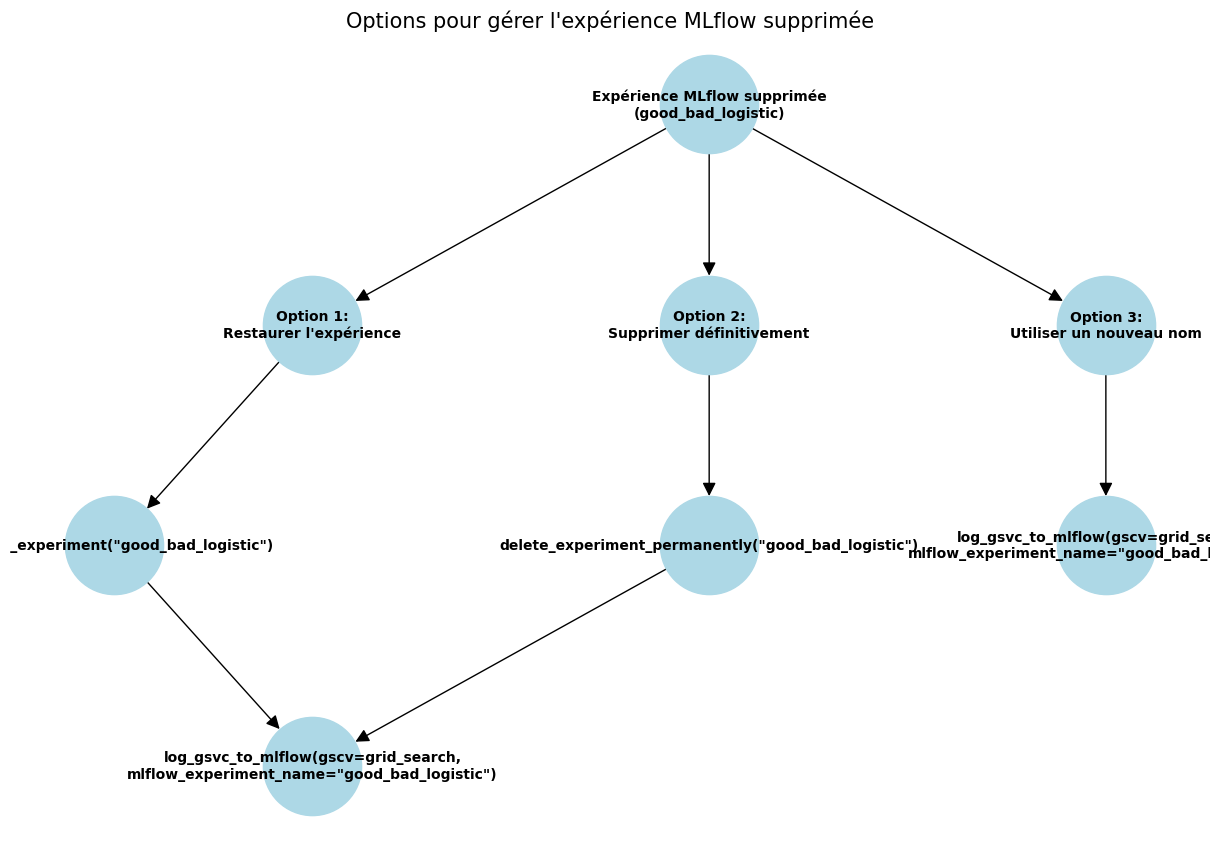

In [41]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes
nodes = {
    'A': 'Expérience MLflow supprimée\n(good_bad_logistic)',
    'B': 'Option 1:\nRestaurer l\'expérience',
    'C': 'Option 2:\nSupprimer définitivement',
    'D': 'Option 3:\nUtiliser un nouveau nom',
    'E': 'restore_experiment("good_bad_logistic")',
    'F': 'delete_experiment_permanently("good_bad_logistic")',
    'G': 'log_gsvc_to_mlflow(gscv=grid_search,\nmlflow_experiment_name="good_bad_logistic")',
    'H': 'log_gsvc_to_mlflow(gscv=grid_search,\nmlflow_experiment_name="good_bad_logistic_v2")'
}

for key, value in nodes.items():
    G.add_node(key, label=value)

# Add edges
edges = [
    ('A', 'B'),
    ('A', 'C'),
    ('A', 'D'),
    ('B', 'E'),
    ('E', 'G'),
    ('C', 'F'),
    ('F', 'G'),
    ('D', 'H')
]

G.add_edges_from(edges)

# Manually set positions to avoid crossing arrows
pos = {
    'A': (0, 0),
    'B': (-1, -1),
    'C': (0, -1),
    'D': (1, -1),
    'E': (-1.5, -2),
    'F': (0, -2),
    'G': (-1, -3),
    'H': (1, -2)
}

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=False, node_size=5000, node_color='lightblue', font_size=10, font_weight='bold', arrows=True, arrowstyle='-|>', arrowsize=20)
labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold')

# Add title
plt.title('Options pour gérer l\'expérience MLflow supprimée', fontsize=15)

plt.show()


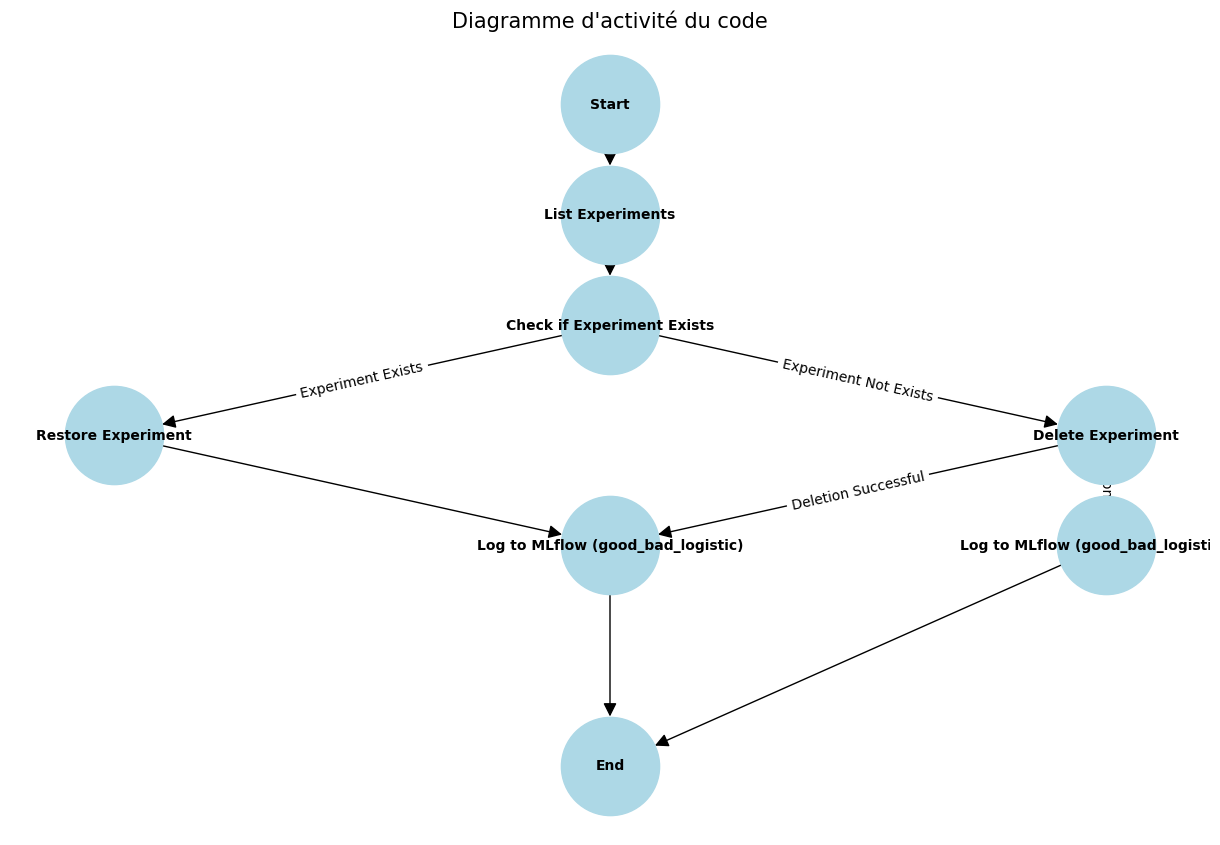

In [42]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_node("Start", label="Start")
G.add_node("List Experiments", label="List Experiments")
G.add_node("Check if Experiment Exists", label="Check if Experiment Exists")
G.add_node("Restore Experiment", label="Restore Experiment")
G.add_node("Log to MLflow (good_bad_logistic)", label="Log to MLflow\n(good_bad_logistic)")
G.add_node("Delete Experiment", label="Delete Experiment")
G.add_node("Log to MLflow (good_bad_logistic_v2)", label="Log to MLflow\n(good_bad_logistic_v2)")
G.add_node("End", label="End")

# Add edges
G.add_edge("Start", "List Experiments")
G.add_edge("List Experiments", "Check if Experiment Exists")
G.add_edge("Check if Experiment Exists", "Restore Experiment", label="Experiment Exists")
G.add_edge("Restore Experiment", "Log to MLflow (good_bad_logistic)")
G.add_edge("Log to MLflow (good_bad_logistic)", "End")
G.add_edge("Check if Experiment Exists", "Delete Experiment", label="Experiment Not Exists")
G.add_edge("Delete Experiment", "Log to MLflow (good_bad_logistic)", label="Deletion Successful")
G.add_edge("Delete Experiment", "Log to MLflow (good_bad_logistic_v2)", label="Deletion Failed")
G.add_edge("Log to MLflow (good_bad_logistic_v2)", "End")

# Manually set positions to avoid crossing arrows
pos = {
    "Start": (0, 6),
    "List Experiments": (0, 5),
    "Check if Experiment Exists": (0, 4),
    "Restore Experiment": (-2, 3),
    "Log to MLflow (good_bad_logistic)": (0, 2),
    "Delete Experiment": (2, 3),
    "Log to MLflow (good_bad_logistic_v2)": (2, 2),
    "End": (0, 0)
}

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=5000, node_color='lightblue', font_size=10, font_weight='bold', arrows=True, arrowstyle='-|>', arrowsize=20)

# Draw edge labels
edge_labels = {
    ("Check if Experiment Exists", "Restore Experiment"): "Experiment Exists",
    ("Check if Experiment Exists", "Delete Experiment"): "Experiment Not Exists",
    ("Delete Experiment", "Log to MLflow (good_bad_logistic)"): "Deletion Successful",
    ("Delete Experiment", "Log to MLflow (good_bad_logistic_v2)"): "Deletion Failed"
}

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# Add title
plt.title('Diagramme d\'activité du code', fontsize=15)

plt.show()


In [44]:
import mlflow
from mlflow.exceptions import RestException

def list_experiments():
    client = mlflow.tracking.MlflowClient()
    experiments = client.search_experiments(view_type=mlflow.entities.ViewType.ALL)
    for exp in experiments:
        print(f"Name: {exp.name}, ID: {exp.experiment_id}, Lifecycle Stage: {exp.lifecycle_stage}")

def restore_experiment(experiment_name):
    client = mlflow.tracking.MlflowClient()
    experiments = client.search_experiments(view_type=mlflow.entities.ViewType.DELETED_ONLY)
    for exp in experiments:
        if exp.name == experiment_name:
            client.restore_experiment(exp.experiment_id)
            print(f"Experiment '{experiment_name}' restored.")
            return True
    print(f"No deleted experiment with the name '{experiment_name}' found.")
    return False

def delete_experiment_permanently(experiment_name):
    client = mlflow.tracking.MlflowClient()
    experiments = client.search_experiments(view_type=mlflow.entities.ViewType.ALL)
    for exp in experiments:
        if exp.name == experiment_name:
            client.delete_experiment(exp.experiment_id)
            print(f"Experiment '{experiment_name}' permanently deleted.")
            return True
    print(f"No experiment with the name '{experiment_name}' found.")
    return False

def log_gsvc_to_mlflow(gscv, mlflow_experiment_name):
    """Log a scikit-learn trained GridSearchCV object as an MLflow experiment."""
    
    # Configurer le contexte de l'expérience MLflow
    mlflow.set_experiment(experiment_name=mlflow_experiment_name)

    for run_idx in range(len(gscv.cv_results_["params"])):
        # Pour chaque combinaison d'hyperparamètres utilisée pour entraîner le modèle, on log une exécution dans MLflow
        run_name = f"run {run_idx}"
        with mlflow.start_run(run_name=run_name):
            # Enregistrer les hyperparamètres
            params = gscv.cv_results_["params"][run_idx]
            for param in params:
                mlflow.log_param(param, params[param])

            # Enregistrer les métriques de fit
            scores = [score for score in gscv.cv_results_ if "mean_test" in score or "std_test" in score]
            for score in scores:
                mlflow.log_metric(score, gscv.cv_results_[score][run_idx])

            # Enregistrer le modèle en tant qu'artifact
            mlflow.sklearn.log_model(gscv, "gscv_model")

def manage_experiment(gscv, experiment_name):
    client = mlflow.tracking.MlflowClient()
    experiments = client.search_experiments(view_type=mlflow.entities.ViewType.ALL)
    
    exp_exists = False
    exp_deleted = False
    
    for exp in experiments:
        if exp.name == experiment_name:
            exp_exists = True
            if exp.lifecycle_stage == 'deleted':
                exp_deleted = True
            break

    if exp_deleted:
        restored = restore_experiment(experiment_name)
        if restored:
            log_gsvc_to_mlflow(gscv, experiment_name)
        else:
            print(f"Failed to restore the experiment '{experiment_name}'.")
    elif exp_exists:
        log_gsvc_to_mlflow(gscv, experiment_name)
    else:
        deleted = delete_experiment_permanently(experiment_name)
        if deleted:
            log_gsvc_to_mlflow(gscv, experiment_name)
        else:
            log_gsvc_to_mlflow(gscv, f"{experiment_name}_v2")

# List all experiments
list_experiments()

# Manage experiment
manage_experiment(grid_search, "good_bad_logistic")


Name: good_bad_logistic, ID: 3, Lifecycle Stage: deleted
Name: nace-prediction, ID: 2, Lifecycle Stage: active
Name: tutorial-mlflow-intro, ID: 1, Lifecycle Stage: active
Name: Default, ID: 0, Lifecycle Stage: active
Experiment 'good_bad_logistic' restored.


La fonction `manage_experiment` :

- Vérifie si l'expérience avec le nom donné existe et si elle est active, supprimée ou inexistante.
- Si elle est supprimée, elle tente de la restaurer puis de logger les résultats.
- Si elle existe et est active, elle logge directement les résultats.
- Si elle n'existe pas, elle tente de la supprimer définitivement et crée une nouvelle expérience si nécessaire, avec un nom différent si la suppression échoue.

Cette logique assure que les résultats sont toujours loggés dans une expérience valide, en gérant soigneusement les différents états possibles de l'expérience dans MLflow.

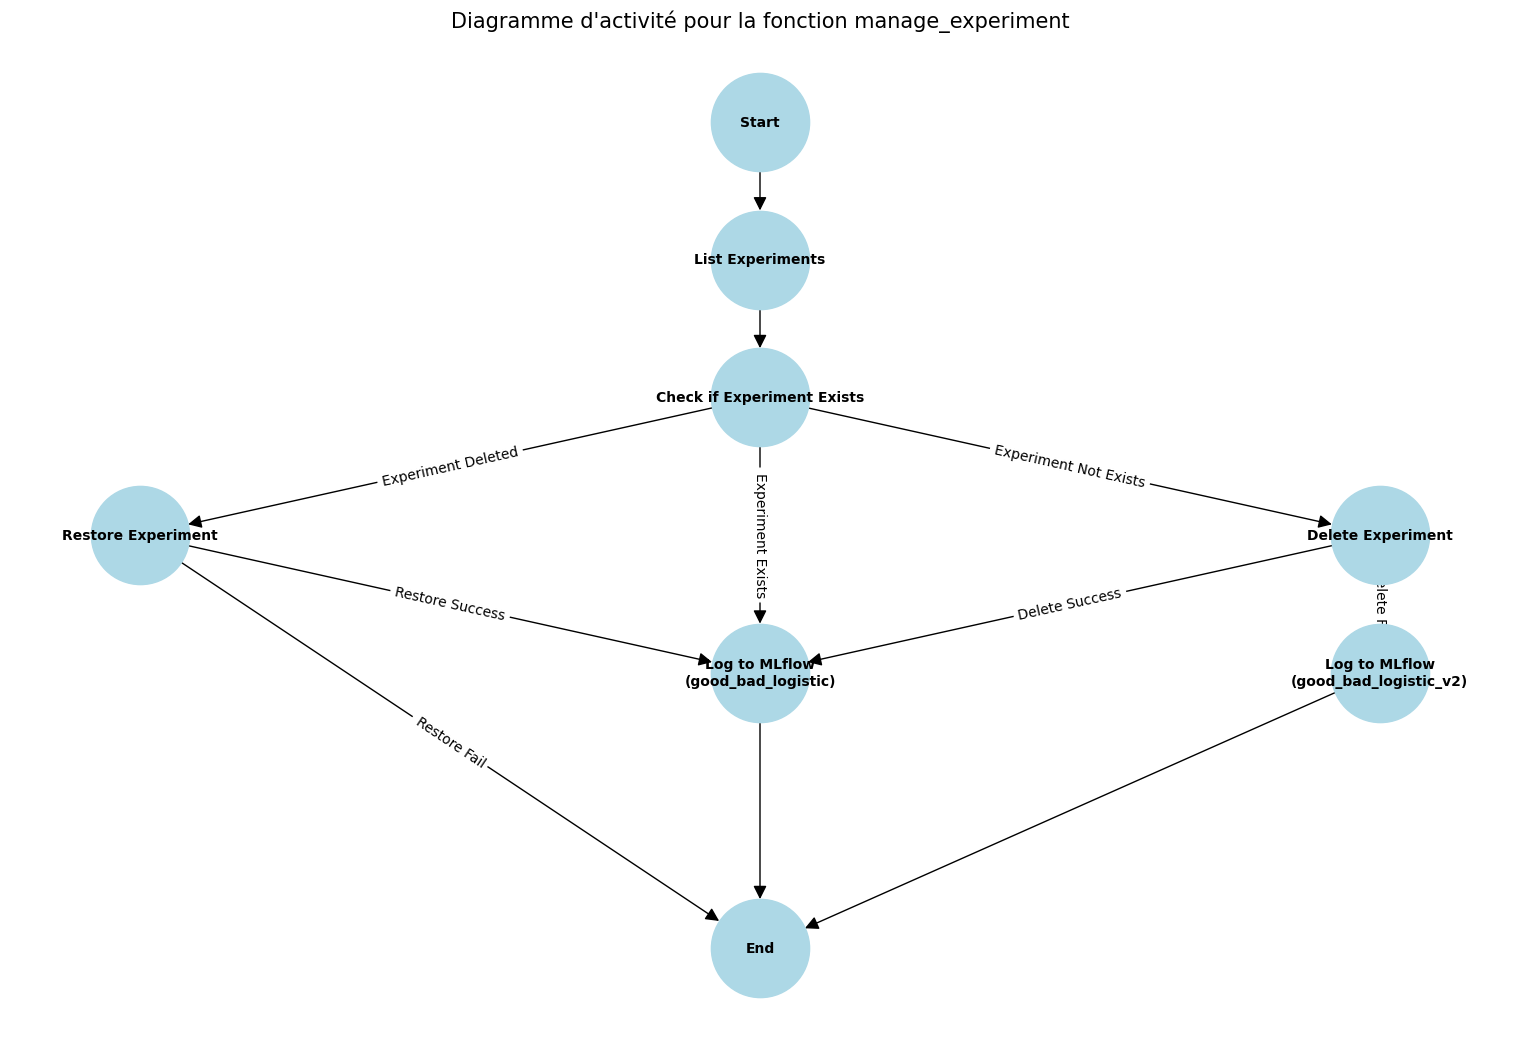

In [45]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes
nodes = {
    'Start': "Start",
    'List Experiments': "List Experiments",
    'Check Experiment Exists': "Check if Experiment Exists",
    'Restore Experiment': "Restore Experiment",
    'Log to MLflow (good_bad_logistic)': "Log to MLflow\n(good_bad_logistic)",
    'Delete Experiment': "Delete Experiment",
    'Log to MLflow (good_bad_logistic_v2)': "Log to MLflow\n(good_bad_logistic_v2)",
    'End': "End"
}

for key, value in nodes.items():
    G.add_node(key, label=value)

# Add edges
edges = [
    ('Start', 'List Experiments'),
    ('List Experiments', 'Check Experiment Exists'),
    ('Check Experiment Exists', 'Restore Experiment', {'label': 'Experiment Deleted'}),
    ('Restore Experiment', 'Log to MLflow (good_bad_logistic)', {'label': 'Restore Success'}),
    ('Restore Experiment', 'End', {'label': 'Restore Fail'}),
    ('Check Experiment Exists', 'Log to MLflow (good_bad_logistic)', {'label': 'Experiment Exists'}),
    ('Check Experiment Exists', 'Delete Experiment', {'label': 'Experiment Not Exists'}),
    ('Delete Experiment', 'Log to MLflow (good_bad_logistic)', {'label': 'Delete Success'}),
    ('Delete Experiment', 'Log to MLflow (good_bad_logistic_v2)', {'label': 'Delete Fail'}),
    ('Log to MLflow (good_bad_logistic)', 'End'),
    ('Log to MLflow (good_bad_logistic_v2)', 'End')
]

G.add_edges_from(edges)

# Define positions
pos = {
    'Start': (0, 6),
    'List Experiments': (0, 5),
    'Check Experiment Exists': (0, 4),
    'Restore Experiment': (-2, 3),
    'Log to MLflow (good_bad_logistic)': (0, 2),
    'Delete Experiment': (2, 3),
    'Log to MLflow (good_bad_logistic_v2)': (2, 2),
    'End': (0, 0)
}

# Draw the graph
plt.figure(figsize=(15, 10))
nx.draw(G, pos, with_labels=False, node_size=5000, node_color='lightblue', font_size=10, font_weight='bold', arrows=True, arrowstyle='-|>', arrowsize=20)

# Draw node labels
labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold')

# Draw edge labels
edge_labels = {('Check Experiment Exists', 'Restore Experiment'): 'Experiment Deleted',
               ('Restore Experiment', 'Log to MLflow (good_bad_logistic)'): 'Restore Success',
               ('Restore Experiment', 'End'): 'Restore Fail',
               ('Check Experiment Exists', 'Log to MLflow (good_bad_logistic)'): 'Experiment Exists',
               ('Check Experiment Exists', 'Delete Experiment'): 'Experiment Not Exists',
               ('Delete Experiment', 'Log to MLflow (good_bad_logistic)'): 'Delete Success',
               ('Delete Experiment', 'Log to MLflow (good_bad_logistic_v2)'): 'Delete Fail'}

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# Add title
plt.title('Diagramme d\'activité pour la fonction manage_experiment', fontsize=15)

plt.show()


### Querying a model

#### Using the version number

In [46]:
# Fetch the model
model_name = "good_bad_logistic"
version = 1

model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{version}")

2024/06/03 12:10:33 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.13.1, required: mlflow==2.12.1)
 - lz4 (current: uninstalled, required: lz4==4.3.3)
 - scikit-learn (current: 1.5.0, required: scikit-learn==1.4.2)
 - scipy (current: 1.13.1, required: scipy==1.13.0)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
/opt/mamba/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.4.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/mamba/lib/python3.12/site-packages/sklearn/

In [47]:
# Final evaluation
y_test_pred = model.predict(X_test)
f1_test = f1_score(y_test, y_test_pred)

print(f"Final F1-score on test data : {f1_test}")

Final F1-score on test data : 0.009221418841035315
